Install required libraries

In [1]:
# Install required libraries
!pip install torch torchvision opencv-python-headless matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Import necessary libraries

In [14]:
# Import the OS library for operating system dependent functionality
import os

# Import OpenCV for image processing tasks
import cv2

# Import the PIL (Pillow) library for image handling and manipulation
import PIL

# Import PyTorch for deep learning operations and model handling
import torch

# Import NumPy for numerical operations and array manipulations
import numpy as np

# Import Matplotlib for plotting and visualizing images
import matplotlib.pyplot as plt

# Import the files module from Google Colab for handling file uploads and downloads
from google.colab import files

# Import the DeepLabV3 models with ResNet architectures for semantic segmentation
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101

# Import pre-trained weights for the DeepLabV3 models
from torchvision.models.segmentation import (
    DeepLabV3_ResNet50_Weights,  # Weights for the ResNet-50 model
    DeepLabV3_ResNet101_Weights   # Weights for the ResNet-101 model
)


Define label map

In [16]:
# Define label map
label_map = np.array([
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

Define helper functions

In [17]:
# Define helper functions for drawing segmentation map
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()  # Get predicted labels
    red_map = np.zeros_like(labels).astype(np.uint8)  # Initialize red channel
    green_map = np.zeros_like(labels).astype(np.uint8)  # Initialize green channel
    blue_map = np.zeros_like(labels).astype(np.uint8)  # Initialize blue channel

    # Create RGB segmentation map based on label map
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        R, G, B = label_map[label_num]
        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)  # Stack channels
    return segmentation_map  # Return the segmentation map

Load model function

In [18]:
"""
    Load a pre-trained DeepLabV3 model.

    Args:
    model_name (str): The name of the model to load ('resnet_50' or 'resnet_101').

    Returns:
    model: The loaded model.
    transforms: The transformation applied to input images.
"""

def load_model(model_name: str):
    if model_name.lower() not in ("resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")

     # Load the specified model and its associated weights
    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
    else:
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()  # Set the model to evaluation mode
    _ = model(torch.randn(1, 3, 520, 520))  # Run a dummy input through the model to load weights
    return model, transforms  # Return the model and transformations

Perform inference function

In [19]:
"""
    Perform image segmentation using the specified model.

    Args:
    model_name (str): The name of the model to use.
    image_path (str): The path to the input image.
    device (str): The device to run the model on ('cuda' or 'cpu').
"""
def perform_inference(model_name: str, image_path=None, device=None):
    device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
    model, transforms = load_model(model_name)  # Load the model and transforms
    model.to(device)    # Move model to the specified device

    img_raw = PIL.Image.open(image_path).convert("RGB")  # Load and convert image to RGB
    W, H = img_raw.size[:2]  # Get image dimensions
    img_t = transforms(img_raw)  # Apply transformations
    img_t = torch.unsqueeze(img_t, dim=0).to(device)  # Add batch dimension and move to device


    with torch.no_grad():  # Disable gradient computation
        output = model(img_t)["out"].cpu()  # Get model output

    segmented_image = draw_segmentation_map(output)  # Create segmentation map
    segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)  # Resize to original dimensions

    # Display original image and segmentation result
    plt.figure(figsize=(12, 10), dpi=100)
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Image")
    plt.imshow(np.asarray(img_raw))

    plt.subplot(1, 3, 2)
    plt.title("Segmentation")
    plt.axis("off")
    plt.imshow(segmented_image)


    plt.show()
    plt.close()

Download and extract Pascal VOC 2012 dataset

In [9]:
# Step 7: Download and extract Pascal VOC 2012 dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

Upload an image and perform inference

In [21]:
"""
    Upload an image and perform segmentation.

    Args:
    model_name (str): The name of the model to use for segmentation.
"""
def upload_and_segment_image(model_name='resnet_50'):
    uploaded = files.upload()  # Upload the image
    for filename in uploaded.keys():  # Process each uploaded file
        perform_inference(model_name=model_name, image_path=filename)  # Perform segmentation

Upload an image for segmentation

Saving human_pet_image.jpg to human_pet_image.jpg


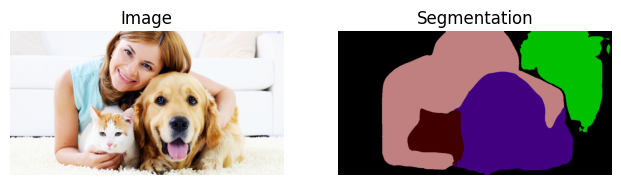

In [24]:
# Step 9: Upload an image and segment it
upload_and_segment_image('resnet_101') # Perform segmentation using ResNet101

Uploading another Image and Performing Image Segmentation

Saving ppl_img2.jpg to ppl_img2.jpg


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:03<00:00, 61.4MB/s]


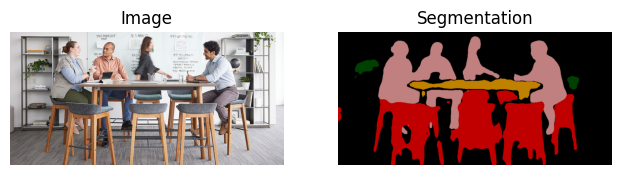

In [10]:
# Step 8: Upload an image and perform inference
def upload_and_segment_image(model_name='resnet_50'):
    uploaded = files.upload()
    for filename in uploaded.keys():
        perform_inference(model_name=model_name, image_path=filename)

# Step 9: Upload an image and segment it
upload_and_segment_image('resnet_101')